In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA


In [65]:
# Charger les données d'entraînement
df = pd.read_csv('farms_train.csv', sep=';', decimal=',')

# Convertir les colonnes en types numériques
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes
df = df.dropna()

# Séparer les caractéristiques et la variable cible
X = df.drop('DIFF', axis=1)
y = df['DIFF']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [66]:
df.head()

,DIFF,R2,R7,R8,R17,R22,R32
0,0,0.705,0.290,0.1334,0.0481,0.5258,0.2941
1,1,0.801,0.213,0.1282,0.0186,2.1411,0.3005
2,1,0.591,0.429,0.2999,0.0800,0.5957,0.4126
3,0,0.373,0.346,1.3704,0.0812,0.3430,0.2265
4,0,0.000,1.417,0.2493,0.0501,0.8728,0.1086


In [67]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']


In [68]:
# Dictionnaire pour stocker les modèles et les résultats
models = {}
results = {}

for kernel in kernels:
    print(f"Entraînement du modèle avec le noyau : {kernel}")

    # Initialiser le modèle SVM
    svm_model = SVC(kernel=kernel, C=1.0, gamma='scale', probability=True, random_state=42)

    # Entraîner le modèle
    svm_model.fit(X_train_scaled, y_train)

    # Prédire sur l'ensemble de validation
    y_pred = svm_model.predict(X_val_scaled)
    y_proba = svm_model.predict_proba(X_val_scaled)[:, 1]  # Probabilité pour la classe positive

    # Stocker les résultats
    models[kernel] = svm_model
    results[kernel] = {
        'y_pred': y_pred,
        'y_proba': y_proba,
        'accuracy': accuracy_score(y_val, y_pred),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'classification_report': classification_report(y_val, y_pred, output_dict=True),
    }


Entraînement du modèle avec le noyau : linear
Entraînement du modèle avec le noyau : poly
Entraînement du modèle avec le noyau : rbf
Entraînement du modèle avec le noyau : sigmoid


<ipython-input-69-c53040394c85>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Noyau', y='Précision', data=accuracy_df, palette='viridis')


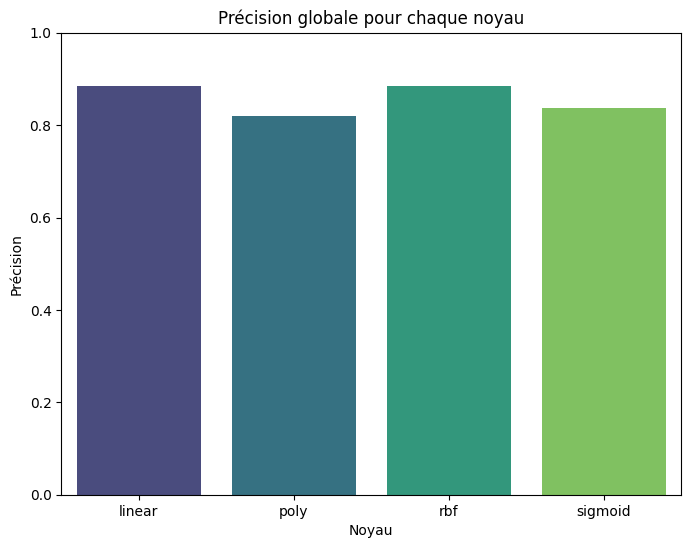

In [69]:
# Extraire les précisions globales
accuracies = [results[kernel]['accuracy'] for kernel in kernels]

# Créer un DataFrame pour les précisions
accuracy_df = pd.DataFrame({
    'Noyau': kernels,
    'Précision': accuracies
})

# Visualiser les précisions
plt.figure(figsize=(8,6))
sns.barplot(x='Noyau', y='Précision', data=accuracy_df, palette='viridis')
plt.title('Précision globale pour chaque noyau')
plt.ylabel('Précision')
plt.xlabel('Noyau')
plt.ylim(0, 1)
plt.show()


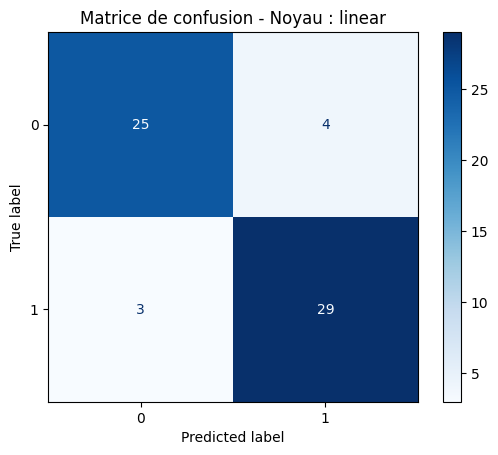

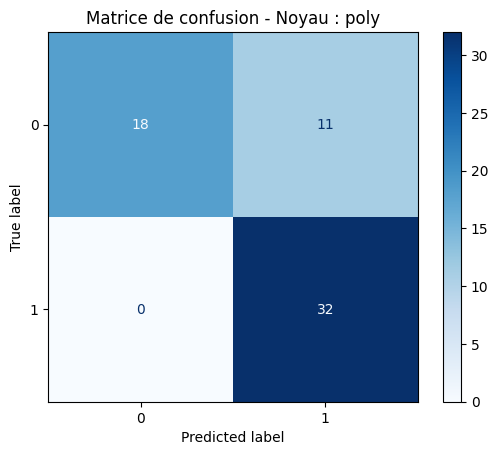

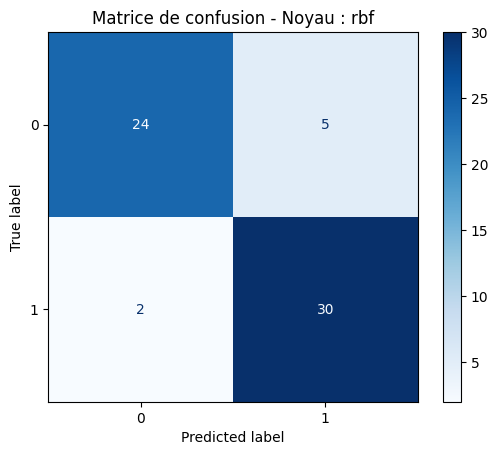

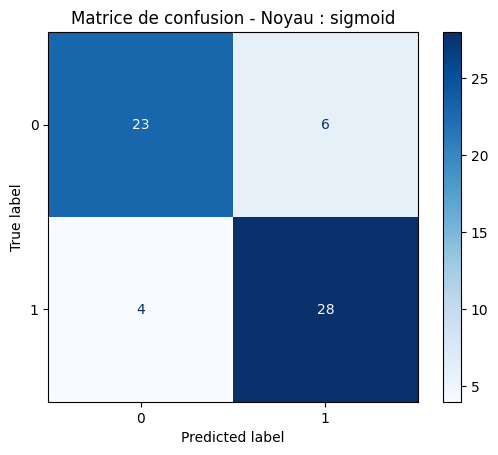

In [70]:
for kernel in kernels:
    cm = results[kernel]['confusion_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[kernel].classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Matrice de confusion - Noyau : {kernel}")
    plt.show()


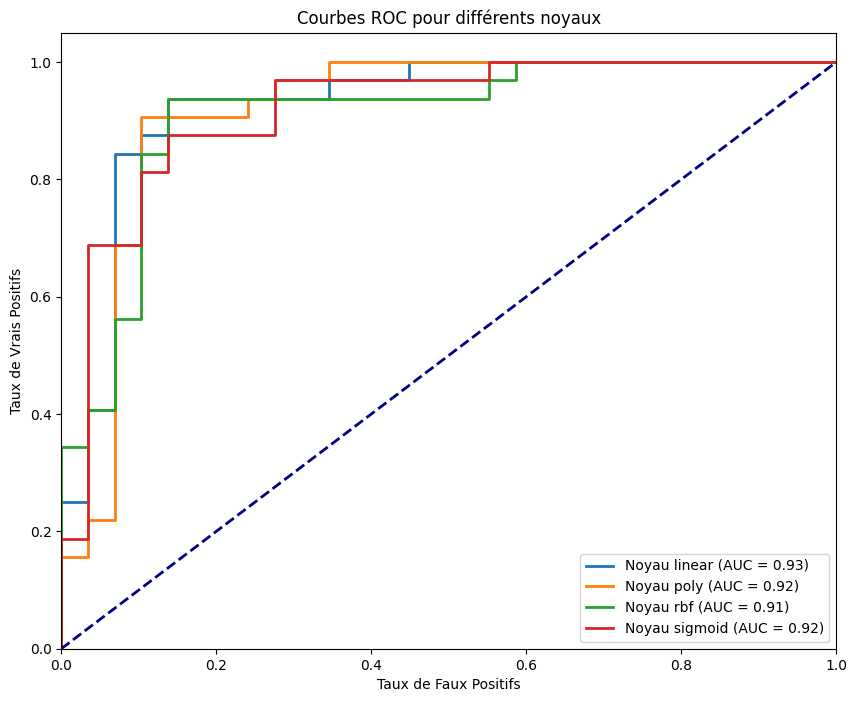

In [71]:
plt.figure(figsize=(10,8))

for kernel in kernels:
    y_proba = results[kernel]['y_proba']
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Noyau {kernel} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC pour différents noyaux')
plt.legend(loc="lower right")
plt.show()


In [72]:
# Appliquer PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


In [73]:
models_pca = {}
results_pca = {}

for kernel in kernels:
    print(f"Entraînement du modèle avec le noyau : {kernel} (PCA)")

    svm_model = SVC(kernel=kernel, C=1.0, gamma='scale', probability=True, random_state=42)
    svm_model.fit(X_train_pca, y_train)
    y_pred = svm_model.predict(X_val_pca)

    models_pca[kernel] = svm_model
    results_pca[kernel] = {
        'y_pred': y_pred,
        'accuracy': accuracy_score(y_val, y_pred),
    }


Entraînement du modèle avec le noyau : linear (PCA)
Entraînement du modèle avec le noyau : poly (PCA)
Entraînement du modèle avec le noyau : rbf (PCA)
Entraînement du modèle avec le noyau : sigmoid (PCA)


In [74]:
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01  # Taille de l'étape dans la maille
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.title(title)
    plt.show()


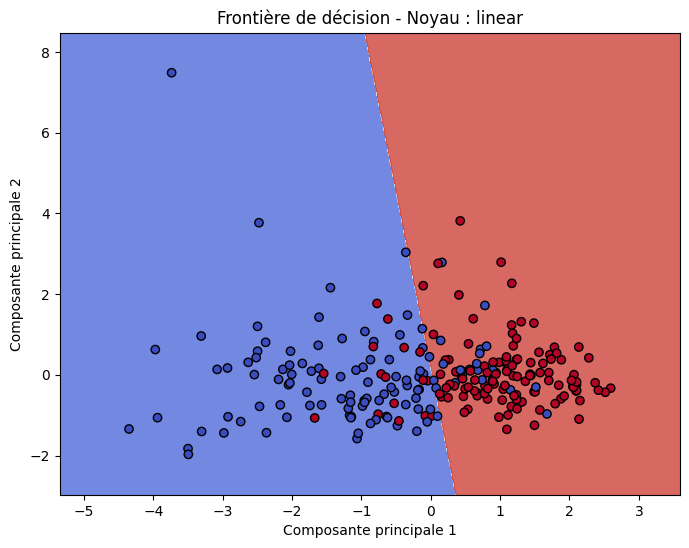

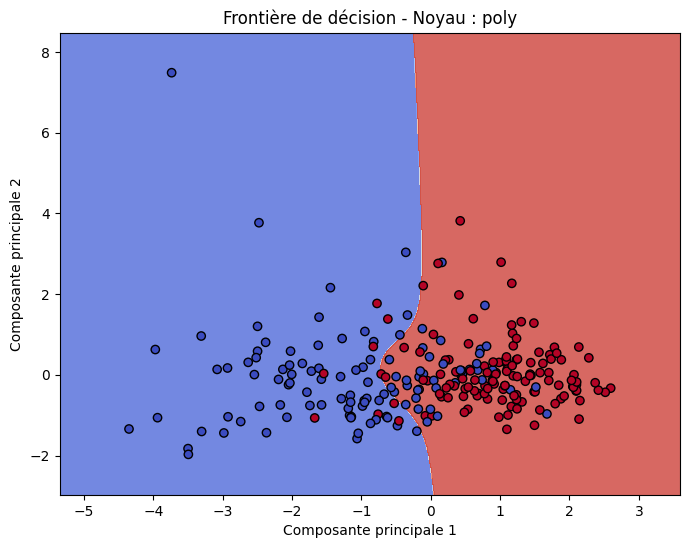

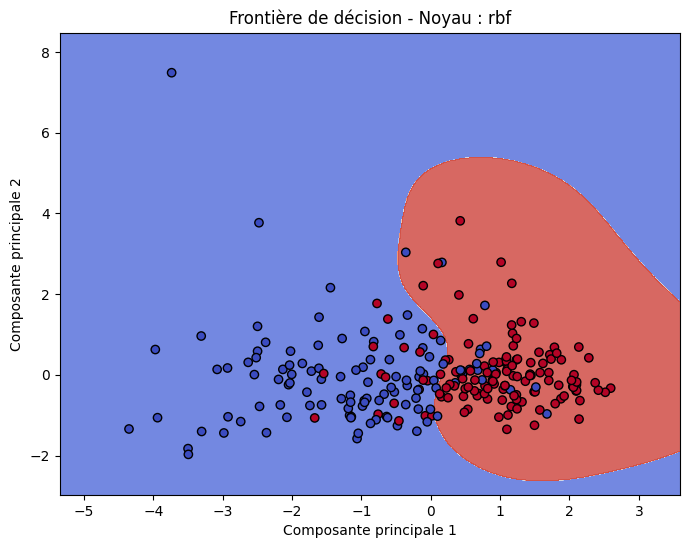

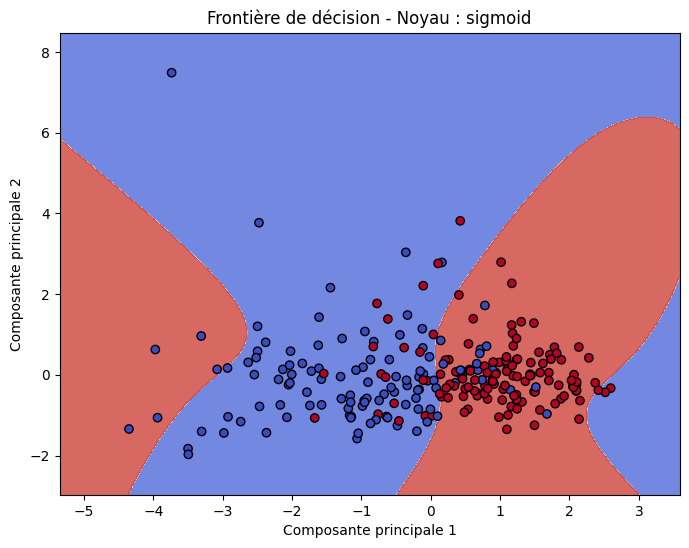

In [55]:
for kernel in kernels:
    plot_decision_boundaries(X_train_pca, y_train, models_pca[kernel], f'Frontière de décision - Noyau : {kernel}')


In [56]:
performance = []

for kernel in kernels:
    report = results[kernel]['classification_report']
    accuracy = results[kernel]['accuracy']
    performance.append({
        'Noyau': kernel,
        'Précision globale': accuracy,
        'Précision (Classe 0)': report['0']['precision'],
        'Rappel (Classe 0)': report['0']['recall'],
        'F1-Score (Classe 0)': report['0']['f1-score'],
        'Précision (Classe 1)': report['1']['precision'],
        'Rappel (Classe 1)': report['1']['recall'],
        'F1-Score (Classe 1)': report['1']['f1-score'],
    })

performance_df = pd.DataFrame(performance)
print(performance_df)


     Noyau  Précision globale  Précision (Classe 0)  Rappel (Classe 0)  \
0   linear           0.885246              0.892857           0.862069   
1     poly           0.819672              1.000000           0.620690   
2      rbf           0.885246              0.923077           0.827586   
3  sigmoid           0.836066              0.851852           0.793103   

   F1-Score (Classe 0)  Précision (Classe 1)  Rappel (Classe 1)  \
0             0.877193              0.878788            0.90625   
1             0.765957              0.744186            1.00000   
2             0.872727              0.857143            0.93750   
3             0.821429              0.823529            0.87500   

   F1-Score (Classe 1)  
0             0.892308  
1             0.853333  
2             0.895522  
3             0.848485  


In [75]:
from sklearn.model_selection import GridSearchCV

# Définir la grille des hyperparamètres à tester
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Seulement utilisé pour le noyau 'poly'
}

# Initialiser GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=2)

# Effectuer la recherche sur les données d'entraînement
grid.fit(X_train_scaled, y_train)

# Afficher les meilleurs paramètres
print("\nMeilleurs paramètres trouvés :")
print(grid.best_params_)

# Utiliser le meilleur modèle trouvé
best_model = grid.best_estimator_

# Prédire sur l'ensemble de validation avec le meilleur modèle
y_pred = best_model.predict(X_val_scaled)

# Évaluer les performances du meilleur modèle
print("\nRapport de classification avec le meilleur modèle :")
print(classification_report(y_val, y_pred))

accuracy = accuracy_score(y_val, y_pred)
print(f"Précision globale : {accuracy:.2f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scal

Entraînement du modèle avec le noyau : linear (ACP)
Précision du modèle avec le noyau linéaire : 0.87
Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        29
           1       0.83      0.94      0.88        32

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



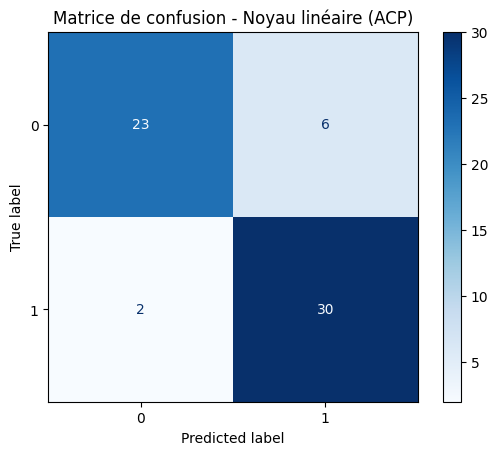

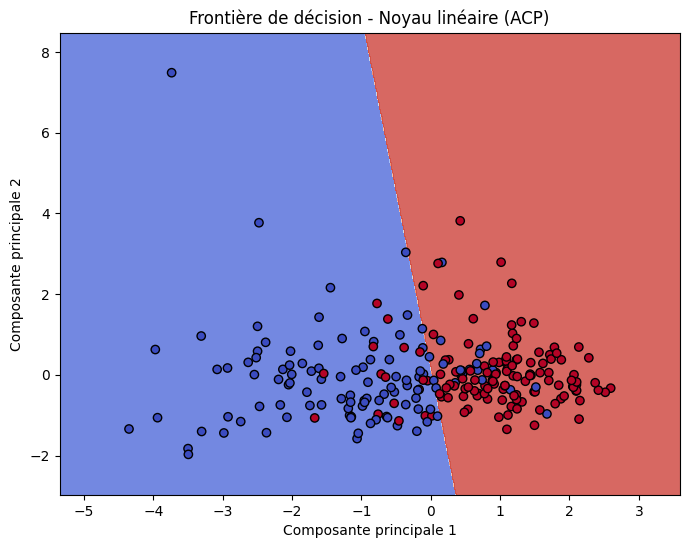

In [79]:
# Initialiser les dictionnaires pour stocker le modèle et les résultats
models_pca = {}
results_pca = {}

# Spécifier le noyau linéaire
kernel = 'linear'
print(f"Entraînement du modèle avec le noyau : {kernel} (ACP)")

# Créer et entraîner le modèle SVM avec le noyau linéaire
svm_model = SVC(kernel=kernel, C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_pca, y_train)

# Prédire sur l'ensemble de validation
y_pred = svm_model.predict(X_val_pca)

# Stocker le modèle et les résultats
models_pca[kernel] = svm_model
results_pca[kernel] = {
    'y_pred': y_pred,
    'accuracy': accuracy_score(y_val, y_pred),
}

# Afficher la précision du modèle
accuracy = results_pca[kernel]['accuracy']
print(f"Précision du modèle avec le noyau linéaire : {accuracy:.2f}")

# Afficher le rapport de classification
from sklearn.metrics import classification_report
print("Rapport de classification :")
print(classification_report(y_val, y_pred))

# Visualiser la matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap='Blues')
plt.title('Matrice de confusion - Noyau linéaire (ACP)')
plt.show()

# Visualiser la frontière de décision
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01  # Taille de l'étape dans la grille
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.title(title)
    plt.show()

# Appeler la fonction pour tracer la frontière de décision
plot_decision_boundaries(X_train_pca, y_train, svm_model, 'Frontière de décision - Noyau linéaire (ACP)')


In [80]:
#  Charger et prétraiter les données de test sans labels
# Remplacez 'farms_test.csv' par le chemin vers votre fichier de test
df_test = pd.read_csv('farms_test_.csv', sep=';', decimal=',', quotechar='"')

# Convertir les colonnes en types numériques
for col in df_test.columns:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes
df_test = df_test.dropna()

# 4. Appliquer la normalisation aux données de test
X_test_scaled = scaler.transform(df_test)

# 5. Faire des prédictions sur les données de test
y_pred = svm_model.predict(X_test_scaled)

# 6. Sauvegarder les prédictions
# Ajouter les prédictions au DataFrame de test
df_test['Prediction'] = y_pred

# Sauvegarder les prédictions dans un fichier CSV
df_test.to_csv('farms_test_predictions.csv', index=False, sep=';', decimal=',')
print("Les prédictions ont été sauvegardées dans 'farms_test_predictions.csv'.")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- R2,"R7","R8","R17","R22","R32"
Feature names seen at fit time, yet now missing:
- R17
- R2
- R22
- R32
- R7
- ...
